# Task 2: Retrieval over corpus
Compute pdist2

- Extract features from MCN

    `bash dump_features.sh`
    
- Move features

    `mv ../localizing-moments/results/*.hdf5 data/interim/mcn/features/`

- Class to parse and interact with corpus
    - ~~reading hdf5~~
    - ~~make dictionary~~
    - ~~~make corpus matrix~~
    - ~~Method to return video and segment~~
    - ~~grab possible segments~~

- Compute distance and retrieve sorted samples for a given vector query
    - optional: batch computation

- Task a
    - ~~data structure for ground-truth.~~

- The __outcome__ of this task are/is:
    - module `corpus.py`
    - class `Queries` in new module `dataset.py`

In [1]:
!python corpus.py
!python didemo.py

18339 (873, 6)
simple test
Traceback (most recent call last):
  File "didemo.py", line 250, in <module>
    dataset = Didemo(data, cues)
  File "didemo.py", line 47, in __init__
    self.lang_interface = LanguageRepresentationMCN(max_words)
  File "didemo.py", line 197, in __init__
    self.rec_embedding = RecurrentEmbedding()
  File "/mnt/ilcompf9d1/user/escorcia/moments-retrieval/glove.py", line 35, in __init__
    vocab = open(vocab_file).readlines()
FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/vocab_glove_complete.txt'


In [2]:
from corpus import Corpus
from dataset import Queries

# Task 3: Implement evaluation code

The metric should reflect the probability of finding a relevant moment, clip inside a video, for a given query `q` among `k` possible moments in the entire corpus.

Given that he have multiple annotations per query inside the same video (accounting for inherent temporal ambiguity), we need a "concensus" or "thresholding" criteria to assess that a given clip is relevant among a pool of annotations.

Note: This is not related to the tIOU threshold. Only a single, golden, annotation would circumvent this problem.

Concensus - thresholding strategies:
- max. Assigns a true if the prediction match any annotation.
Makes problem easier as the chance increases proportionally to ambiguity of query. It's sensitive to outliers in annotation process. Probably relevant for tIOU.

Metrics

- R@k,c

    prob of finding a moment on `top-k`.
    Here, the moment is relevant when its average rank on the best 3 out of 4 annotations is lower or equal than `j`.

- mIOU

   
- mRank
    mean rank.


~~Among the thresholding strategies, we have:~~

~~- average. Makes problem harder as it forces to agree with multiple annotators. It's also sensitive to outliers.~~

~~- average over a subset of annotations. As above but accounting for outliers.~~

~~Thresholding implies to compute a given metric a measure the~~
~~For consistency with DiDeMo standard, we opt for thresholding:~~

Implementation note: given multiple annotations for each query is not conveninent to deal with the raw indexes from the feature matrix. Moreover, those indexes would be useless for considering tIOU. Hopefully, we have a function to invert those indexes into video and segment indexes. However, we need to keep consistency in the list of videos and segments to make an apple 2 apple comparsion.

Evaluation pseudo-code

```
inputs: list of queries; ground-truth, k

recall_at_k = []
miou = []
for each query:
    get vector
    compute distance and return sorted list of indexes
    # prediction would end here
    # code for server could continue to provide more info.
    # like red to miss and green for hit ;)
    
    # evaluation
    for i in range(k)
        if video_idx[i] == gt[query][video_idx]:
            check if it's the segment we are looking for
            miou.append()
        else:
            miou.append(0)

sum(recall_at_k) / len(recall_at_k)
sum(miou_at_k) / len(miou_at_k)
```

TODO: what is the average iou in this case? max/mean - average_iou

DiDeMo evaluation

```python
average_ranks = []
average_iou = []
for s, d in zip(segments, data):
  pred = s[0]
  ious = [iou(pred, t) for t in d['times']]
  average_iou.append(np.mean(np.sort(ious)[-3:]))
  ranks = [rank(s, t) for t in d['times']]
  average_ranks.append(np.mean(np.sort(ranks)[:3]))
rank1 = np.sum(np.array(average_ranks) <= 1)/float(len(average_ranks))
rank5 = np.sum(np.array(average_ranks) <= 5)/float(len(average_ranks))
miou = np.mean(average_iou)
```

- TODO
    - weak agreement
    - unit-test vs lisa's code
    - consistency for indexing. avoid to ???

- The __outcome__ of this task is/are:
    - the module `np_segments_ops.py`
    - the class `RetrievalEvaluation`

In [3]:
!python np_segments_ops.py
!python evaluation.py

R@(1, 5, 10)=[0.004545454545454545, 0.014114832535885167, 0.027033492822966507];
R@(1, 5, 10),0.1=[0.006220095693779904, 0.018660287081339714, 0.03373205741626794];
R@(1, 5, 10),didemo=[0.003827751196172249, 0.009330143540669857, 0.01555023923444976];
mIOU=0.0043;
mRank=1657.46;
Elapsed time: 30.823062658309937


In [3]:
from np_segments_ops import iou as segments_iou
from evaluation import RetrievalEvaluation

In [5]:
import h5py

val_rgb_corpus = 'data/interim/mcn/features/corpus_val.hdf5'
val_rgb_queries = 'data/interim/mcn/features/queries_val.hdf5'
val_annotations = 'data/raw/val_data.json'
val_judge = RetrievalEvaluation(val_rgb_corpus, val_annotations, (1, 5, 10))

with h5py.File(val_rgb_queries, 'r') as fid:
    import time
    start = time.time()
    for sample_key, h5ds in fid.items():
        query_id = int(sample_key)
        query_vector = h5ds[:]
        val_judge.eval_single_vector(query_vector, query_id)
    performace = val_judge.eval()
    print('Validation RGB')
    print('R@{0:}={2:};\nR@{0:},{1:}={3:};\nR@{0:},didemo={4:};\n'
          'mIOU={5:.4f};\nmRank={6:.2f};'
          .format(val_judge.k, val_judge.iou_threshold,
                  *performace))
    print('Elapsed time:', time.time() - start)

Validation RGB
R@(1, 5, 10)=[0.004545454545454545, 0.014114832535885167, 0.027033492822966507];
R@(1, 5, 10),0.75=[0.004545454545454545, 0.014114832535885167, 0.027033492822966507];
R@(1, 5, 10),didemo=[0.003827751196172249, 0.009330143540669857, 0.01555023923444976];
mIOU=0.0043;
mRank=1657.46;
Elapsed time: 29.125818014144897


In [8]:
import h5py

val_flow_corpus = 'data/interim/mcn/features/corpus_val_flow.hdf5'
val_flow_queries = 'data/interim/mcn/features/queries_val_flow.hdf5'
val_annotations = 'data/raw/val_data.json'
val_judge = RetrievalEvaluation(val_flow_corpus, val_annotations, (1, 5, 10))

with h5py.File(val_flow_queries, 'r') as fid:
    import time
    start = time.time()
    for sample_key, h5ds in fid.items():
        query_id = int(sample_key)
        query_vector = h5ds[:]
        val_judge.eval_single_vector(query_vector, query_id)
    performace = val_judge.eval()
    print('Validation Flow')
    print('R@{0:}={2:};\nR@{0:},{1:}={3:};\nR@{0:},didemo={4:};\n'
          'mIOU={5:.4f};\nmRank={6:.2f};'
          .format(val_judge.k, val_judge.iou_threshold,
                  *performace))
    print('Elapsed time:', time.time() - start)

Validation Flow
R@(1, 5, 10)=[0.004545454545454545, 0.01555023923444976, 0.03110047846889952];
R@(1, 5, 10),0.75=[0.004545454545454545, 0.01555023923444976, 0.03110047846889952];
R@(1, 5, 10),didemo=[0.004784688995215311, 0.00909090909090909, 0.016507177033492824];
mIOU=0.0045;
mRank=1597.16;
Elapsed time: 29.787809133529663


In [9]:
import h5py

test_rgb_corpus = 'data/interim/mcn/features/corpus_test.hdf5'
test_rgb_queries = 'data/interim/mcn/features/queries_test.hdf5'
test_annotations = 'data/raw/test_data.json'
test_judge = RetrievalEvaluation(test_rgb_corpus, test_annotations, (1, 5, 10))

with h5py.File(test_rgb_queries, 'r') as fid:
    import time
    start = time.time()
    for sample_key, h5ds in fid.items():
        query_id = int(sample_key)
        query_vector = h5ds[:]
        test_judge.eval_single_vector(query_vector, query_id)
    performace = test_judge.eval()
    print('Test RGB')
    print('R@{0:}={2:};\nR@{0:},{1:}={3:};\nR@{0:},didemo={4:};\n'
          'mIOU={5:.4f};\nmRank={6:.2f};'
          .format(test_judge.k, test_judge.iou_threshold,
                  *performace))
    print('Elapsed time:', time.time() - start)

Test RGB
R@(1, 5, 10)=[0.003481720964934096, 0.014175578214374533, 0.02561551852772942];
R@(1, 5, 10),0.75=[0.003481720964934096, 0.014175578214374533, 0.02561551852772942];
R@(1, 5, 10),didemo=[0.002238249191743347, 0.007212136284506341, 0.014921661278288983];
mIOU=0.0028;
mRank=1540.61;
Elapsed time: 26.918400526046753


In [10]:
import h5py

test_flow_corpus = 'data/interim/mcn/features/corpus_test_flow.hdf5'
test_flow_queries = 'data/interim/mcn/features/queries_test_flow.hdf5'
test_annotations = 'data/raw/test_data.json'
test_judge = RetrievalEvaluation(test_flow_corpus, test_annotations, (1, 5, 10))

with h5py.File(test_flow_queries, 'r') as fid:
    import time
    start = time.time()
    for sample_key, h5ds in fid.items():
        query_id = int(sample_key)
        query_vector = h5ds[:]
        test_judge.eval_single_vector(query_vector, query_id)
    performace = test_judge.eval()
    print('Test Flow')
    print('R@{0:}={2:};\nR@{0:},{1:}={3:};\nR@{0:},didemo={4:};\n'
          'mIOU={5:.4f};\nmRank={6:.2f};'
          .format(test_judge.k, test_judge.iou_threshold,
                  *performace))
    print('Elapsed time:', time.time() - start)

Test RGB
R@(1, 5, 10)=[0.004973887092762994, 0.01840338224322308, 0.030838099975130564];
R@(1, 5, 10),0.75=[0.004973887092762994, 0.01840338224322308, 0.030838099975130564];
R@(1, 5, 10),didemo=[0.004476498383486694, 0.011937329022631187, 0.01840338224322308];
mIOU=0.0046;
mRank=1570.50;
Elapsed time: 30.41560411453247


In [1]:
import itertools
import h5py
from evaluation import RetrievalEvaluation

loss_set = ['', '_intra', '_inter']
cue_set = ['rgb', 'flow']
subset_set = ['val', 'test']

time_breakdown = []

def format_loss(x):
    if '_' in x:
        return x.replace('_', '')
    elif len(x) == 0:
        return 'intra+inter'
    return x

for loss, cue, subset in itertools.product(*[loss_set, cue_set, subset_set]):
    corpus_file = f'data/interim/mcn{loss}/corpus_{subset}_{cue}.hdf5'
    queries_file = f'data/interim/mcn{loss}/queries_{subset}_{cue}.hdf5'
    annotations_file = f'data/raw/{subset}_data.json'
    judge = RetrievalEvaluation(corpus_file, annotations_file, (1, 5, 10, 100, 1000))

    with h5py.File(queries_file, 'r') as fid:
        import time
        start = time.time()
        for sample_key, h5ds in fid.items():
            query_id = int(sample_key)
            query_vector = h5ds[:]
            judge.eval_single_vector(query_vector, query_id)
        time_breakdown.append([time.time() - start])
    start = time.time()
    performace = judge.eval()
    time_breakdown[-1].append(time.time() - start)
    loss = format_loss(loss)
    print(f'{loss} {subset} {cue}')
    print('R@{0:}={2:};\nR@{0:},{1:}={3:};\nR@{0:},didemo={4:};\n'
          'mIOU={5:.4f};\nmRank={6:.2f};'
          .format(judge.k, judge.iou_threshold,
                  *performace))
    print()

intra+inter val rgb
R@(1, 5, 10, 100, 1000)=[0.004545454545454545, 0.014114832535885167, 0.027033492822966507, 0.1715311004784689, 0.5937799043062201];
R@(1, 5, 10, 100, 1000),0.75=[0.004545454545454545, 0.014114832535885167, 0.027033492822966507, 0.1715311004784689, 0.5947368421052631];
R@(1, 5, 10, 100, 1000),didemo=[0.003827751196172249, 0.009330143540669857, 0.01555023923444976, 0.10047846889952153, 0.45382775119617225];
mIOU=0.0043;
mRank=1657.46;
intra+inter test rgb
R@(1, 5, 10, 100, 1000)=[0.003481720964934096, 0.014175578214374533, 0.02561551852772942, 0.15443919423029098, 0.5884108430738623];
R@(1, 5, 10, 100, 1000),0.75=[0.003481720964934096, 0.014175578214374533, 0.02561551852772942, 0.15518527729420542, 0.589654314847053];
R@(1, 5, 10, 100, 1000),didemo=[0.002238249191743347, 0.007212136284506341, 0.014921661278288983, 0.0890325789604576, 0.44093509077343945];
mIOU=0.0028;
mRank=1540.61;
intra+inter val flow
R@(1, 5, 10, 100, 1000)=[0.004545454545454545, 0.0155502392344497

## Task 5: Create GIF

~~- Check tar file: only flow files~~

1. Dump video list.

    check notebook `1-inspect_videos.ipynb` section 1.2.d or 1.2.a-b
    
2. Make single GIF
    libs := imageio
    Run gif example

    Take a look a `make_gif.py`

    ~~TODO: Joblib for training~~
    
    _Note_: upload videos to youtube or S3 for AMT
    
## Task 6: Data for backend

In [1]:
import json
import h5py
import numpy as np
from corpus import Corpus
from dataset import Queries

val_rgb_corpus = 'data/interim/mcn/corpus_test_rgb.hdf5'
val_flow_corpus = 'data/interim/mcn/corpus_test_flow.hdf5'
val_rgb_queries = 'data/interim/mcn/queries_test_rgb.hdf5'
val_flow_queries = 'data/interim/mcn/queries_test_flow.hdf5'
val_annotations = 'data/raw/test_data.json'
filename = 'test_results_rgb+flow.json'

val_rgb_corpus = Corpus(val_rgb_corpus)
val_flow_corpus = Corpus(val_flow_corpus, videos=val_rgb_corpus.videos)
segments = list(map(tuple, val_rgb_corpus.segments.tolist()))
val_gt_queries = Queries(
    val_annotations, val_rgb_corpus.videos.tolist(), segments)
TOPK = 20
ALPHA = 0.5
IOU_THRESHOLD = 1.0
UNIQUE_VIDEOS_AT_K = 8
# segments_ = val_rgb_corpus.segments * 5
# segments_[:, 1] += 5
# IOU_MATRIX = segments_iou(segments_, segments_)

retrieval_results = {}
segment_list = []
# Collect samples to visualize
good_samples = []
bad_samples = []
nms_samples = []

num_unique_videos = []
video_retrieved = []

with h5py.File(val_rgb_queries, 'r') as frgb, h5py.File(val_flow_queries, 'r') as fflow:
    for sample_key, h5ds in frgb.items():
        query_id = int(sample_key)
        query_rgb = h5ds[:]
        query_flow = fflow[sample_key][:]
        
        rgb_distance = val_rgb_corpus.search(query_rgb)
        flow_distance = val_flow_corpus.search(query_flow)
        distance = ALPHA * rgb_distance + (1 - ALPHA) * flow_distance
        # Manual indexing
        distance_sorted_indices = np.argsort(distance)
        distance_sorted = distance[distance_sorted_indices]
        results = val_rgb_corpus.ind_to_repo(distance_sorted_indices)
        results = results + (distance_sorted,)
        # Keep topk (visualization purpose)
        topk_video_indices = results[0][:TOPK]
        topk_segment_indices = results[1][:TOPK]
        topk_score = results[2][:TOPK]
        # ground truth information
        query = val_gt_queries[query_id]['description']
        gt_video_index = val_gt_queries[query_id]['video_index']
        gt_segment_indices = val_gt_queries[query_id]['segment_indices']
        # Label predictions as TP/FP
        tp_fp_videos = topk_video_indices == gt_video_index
        tp_fp_segments = np.in1d(topk_segment_indices, gt_segment_indices)
        tp_fp_labels = np.logical_and(tp_fp_videos, tp_fp_segments)
        # Flexible criteria for TP
        # i, j = np.meshgrid(gt_segment_indices, topk_segment_indices)
        # topk_iou = np.max(tp_fp_videos[:, None] * IOU_MATRIX[i, j],
        #                   axis=1)
        # tp_fp_labels_soft = topk_iou >= IOU_THRESHOLD
        # cum_tp_fp_labels = tp_fp_labels_soft.cumsum()
        # Categorize results
        if np.all(tp_fp_labels) == False:
            bad_samples.append(query_id)
        if np.any(tp_fp_labels) == True:
            good_samples.append(query_id)
        unique_videos = np.unique(topk_video_indices)
        if len(unique_videos) < UNIQUE_VIDEOS_AT_K:
            nms_samples.append(query_id)
            
        num_unique_videos.append(len(unique_videos))
        video_retrieved.append(np.any(tp_fp_videos))
        
        retrieval_results[query_id] = {
            'query': query,
            'topk_video_indices': topk_video_indices.tolist(),
            'topk_segment_indices': topk_segment_indices.tolist(),
            'topk_scores': topk_score.tolist(),
            'groundtruth_video_index': gt_video_index,
            'groundtruth_segment_indices': gt_segment_indices.tolist(),
            'tp_fp_labels': tp_fp_labels.tolist(),
            # info about query
            'retrieved_at_k': bool(np.any(tp_fp_labels)),
            'num_unique_videos': len(unique_videos),
            'is_video_retrieved': bool(np.any(tp_fp_videos)),
        }
video_list = val_rgb_corpus.videos.tolist()

with open(filename, 'w') as f:
    json.dump({'results': retrieval_results,
               'videos': video_list,
               'segments': segments},
              f)

# Dump samples to check
import random
for subset, queries in [('Good.txt', good_samples),
                        ('Bad.txt', bad_samples),
                        ('NMS.txt', nms_samples)]:
    with open(subset, 'w') as f:
        for i in queries:
            f.write('{}\n'.format(i))
    print(subset)
    random.shuffle(queries)
    for i in queries[:10]:
        print(val_gt_queries[i]['description'])
    print()

Good.txt
the camera zooms in and out on a group performing in front of people.
the woman enter the building.
fade in from black
there is bush in the bottom left corner
a brown haired boy puts his hand on his head.
zoom in on bird
man in multi colored hat enters frame
the girl smiles near the baby.
the cameraman reaches down and plays some keys on the piano.
we see a bird skim the water ' fly away

Bad.txt
a young boy pushes pillows off himself.
the cameraman wobbles the camera as he comes in closer.
slack rope walker takes first step
jet plane circles around to the left side for the first time
we pass a orangish/yellowish marker during takeoff
camera begins first pan to the right.
both cats jump up onto the white bed
camera first moves to the left just slightly
baby in purple bib smiles as the camera zooms in
a man in a black suit turns to a woman in a red suit.

NMS.txt
the dj is proud of the music he's playing.
water is completely in view on beach
both dogs get on a pillow located on

In [ ]:
print('Pctg video retrieved', sum(video_retrieved) / len(video_retrieved))
print('Median number of unique videos', np.median(num_unique_videos))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook

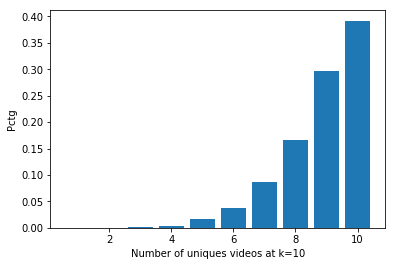

In [26]:
y = np.bincount(num_unique_videos)
plt.bar(range(1, 11), y[1:] / len(num_unique_videos))
plt.ylabel('Pctg')
_ = plt.xlabel('Number of uniques videos at k=10')

# Formalizing metrics

## draft

$\text{HIT}(p_i^j) = \underset{k}{\max} ( \text{tIOU}(p_i^j, a_k^l) \ge \delta)$

- The prediction $p_i^j$ refers to $i\text{-th}$ moment found in video $j$.

- The $\text{HIT}(p_i^j)$ is a binary variable.

- $\text{HIT}$ is True iff:
    - There is an annotation $a_k^j$ in the video $j$, i.e. $j=l$.
        - TODO: missing concept of query

    - The overlap between the prediction $c_i$ and an annotation $a_k$ is greater or equal than $\delta$.
    
    - We apply a consensus function such as $\max$ to deal with multiple annotations.
        
I didn't like the sub-index in the $p$. I don't think that it's necessary.

Let's assume that we only care about the top-1 prediction for a single query.

$\text{HIT}(p^j) = \underset{k}{\max} ( \text{tIOU}(p^j, a_k^l) \ge \delta)$

- The prediction $p^j$ refers to $i\text{-th}$ moment found in video $j$.

- $\text{HIT}(p^j)$ is a binary variable. True means that we are able to retrieve the query from the corpus.

- $\text{HIT}$ is True iff:
    - There is an annotation $a_k^j$ in the video $j$, i.e. $j=l$.

    - The overlap between the prediction $c_i$ and an annotation $a_k$ is greater or equal than $\delta$.
    
    - The $\max$ function is a form of consensus that allows to deal with multiple annotations.
    
    - Opinion: $\max$ might achieve the same purpose than using lower values of $\delta$ with a single annotation.
    
        - TODO: check IOU between annotations per query.
    
In general,

$\text{HIT}(p^j) = f_{\mathcal{A}} ( \text{tIOU}(p^j, a_k^l) \ge \delta)$

- How to define $f_{\mathcal{A}}$? Is it out of the scope of the project?

## Measuring weak agreement

- 1st criterion: Annotations match either start or end.

    Comment: I found this is True.

- 2nd criterion: I fstart/end does not match, they are off at most by 1.

    - This is criterios is not always valid. However, it applies for 96% of the queries.
    
    - When it does not apply, it is feasible to do majority voting.

In [2]:
import json
import numpy as np
VALID_OFFSETS = [-1, 1]
MIN_TIME, MAX_TIME = 0, 5

filename = 'data/raw/{}_data.json'
no_weak_agreement = {}
for subset in ['train', 'val', 'test']:
    with open(filename.format(subset), 'r') as f:
        data = json.load(f)
    
    no_weak_agreement[subset] = {'offset': [],
                                 'alternatives': [],
                                 'majority': []}
    nwa_by_offset = no_weak_agreement[subset]['offset']
    nwa_alternatives = no_weak_agreement[subset]['alternatives']
    nwa_majority = no_weak_agreement[subset]['majority']
    print('Subset:', subset)
    for query in data:
        annotations = np.array(query['times'])
        start, end = np.split(annotations, 2, axis=1)
        start_matched_other = np.equal(start, start[:, None]).sum(axis=1) > 1
        end_matched_other = np.equal(end, end[:, None]).sum(axis=1) > 1
        start_or_end_matched_other = np.logical_or(start_matched_other,
                                                   end_matched_other)
        assert start_or_end_matched_other.any()
        # if all are equal, no purpose of testing offset
        unique_intervals, counts = np.unique(annotations, axis=0, return_counts=True)
        if unique_intervals.shape[0] == 1:
            continue

        start_off_match = np.zeros(start.shape, dtype=bool)
        end_off_match = np.zeros(end.shape, dtype=bool)
        for offset in VALID_OFFSETS:
            start_off = np.minimum(np.maximum(start + offset, MIN_TIME), MAX_TIME)
            start_off_matched_other = np.equal(start_off, start[:, None]).sum(axis=1) >= 1
            start_off_match = np.logical_or(
                start_off_matched_other, start_off_match)

            end_off = np.minimum(np.maximum(end + offset, MIN_TIME), MAX_TIME)
            end_off_matched_other = np.equal(end_off, end[:, None]).sum(axis=1) >= 1
            end_off_match = np.logical_or(
                end_off_matched_other, end_off_match)
        start_or_end_off_matched_other = np.logical_or(start_off_match,
                                                       end_off_match)
        if not start_or_end_off_matched_other.any():
            nwa_by_offset.append(query['annotation_id'])
            nwa_alternatives.append(len(unique_intervals))
            nwa_majority.append(counts.max() / counts.sum() > 0.5)
    print('Number of annomalies:', len(nwa_by_offset))
    print('Pctg of annomalies:', len(nwa_by_offset) / len(data))
    print('Alternatives if anomaly:', np.unique(nwa_alternatives))
    print('Pctg majority if anomaly:', sum(nwa_majority) / len(nwa_majority))
    print()

Subset: train
Number of annomalies: 864
Pctg of annomalies: 0.026177851840630206
Alternatives if anomaly: [2]
Pctg majority if anomaly: 1.0

Subset: val
Number of annomalies: 98
Pctg of annomalies: 0.023444976076555026
Alternatives if anomaly: [2]
Pctg majority if anomaly: 1.0

Subset: test
Number of annomalies: 105
Pctg of annomalies: 0.02611290723700572
Alternatives if anomaly: [2]
Pctg majority if anomaly: 1.0



TODO

- Make table with MCN results (1 hour)

- Beyond metric preformance:

    - retrieved or not at K (add column to enable for sorting)
    
    - retrieved video at k
    
        - compute number
        
    - number of unique videos at k
    
    - max number of segments per video, retrieved at k.